*UID* 118775876, 119207666, 118495965


# **CMSC426 Project 2: Panorama Stitching**

# Introduction

The aim of this project is to implement an end-to-end pipeline for panorama stitching. We all use the panorama mode on our smart-phones– you’ll implement a pipeline which does the same basic thing!

This document just provides an overview of what you need to do. For a full breakdown of how each step in the pipeline works, see the [course notes](https://cmsc426.github.io/pano/) for this project.

# System Overview
Here’s a system diagram, showing each step in your panorama-stitching pipeline:
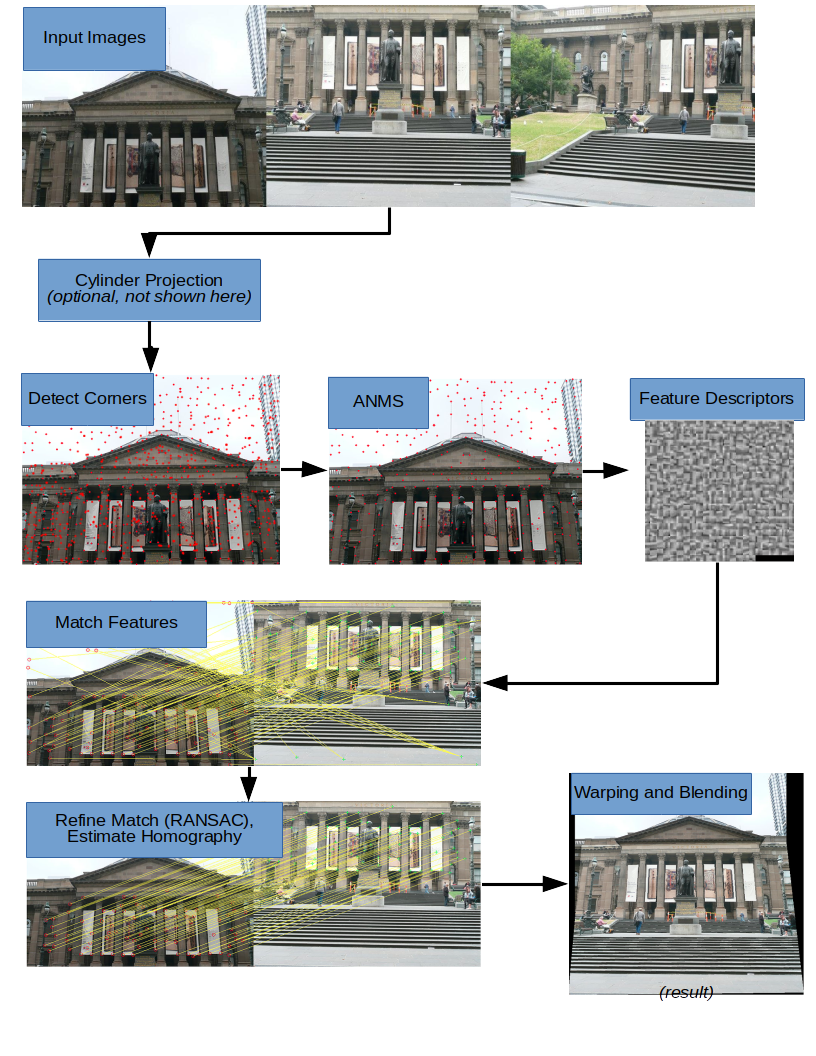







In [1]:
# Download training images from Google Drive
import gdown
gdown.download_folder(id="1VAB_BG2gntlkwR059zR_8gd9pXajzgIk", quiet=True, use_cookies=False)
gdown.download_folder(id="1OmS_qW8fO19_cTPPOCzZf2fmgnPZE6IF", quiet=True, use_cookies=False)

False

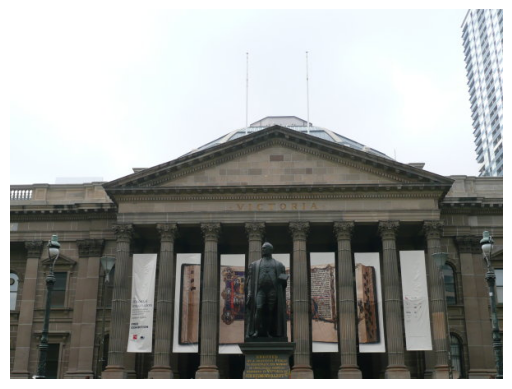

In [2]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

train_image = mpimg.imread('/content/train_images/Set1/1.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

### 1. Detect Corners and Adaptive Non-Maximal Suppression (or ANMS) [25 points]


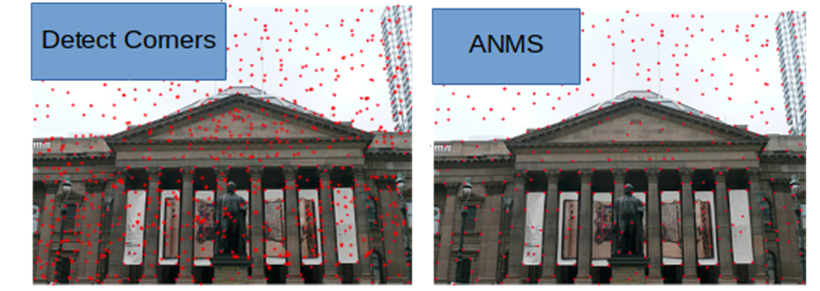

#### Step 1: Corner Detection

The first step in stitching a panorama is extracting corners like most computer vision tasks. Here we will use either Harris corners or Shi-Tomasi corners. Use **cv2.cornerHarris** or **cv2.goodFeaturesToTrack** to implement this part.


In [3]:
from google.colab.patches import cv2_imshow

In [4]:
### Corner Detection
# 1) Convert image to gray scale image
# 2) Run harris or other corner detection from cv2 (cv2.cornerHarris OR cv2.goodFeaturesToTrack, etc.)
# Show the corner detection results for one image!!!

import cv2
import numpy as np

def detect_corner(img):
    # 1) Convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Run harris or other corner detection from cv2
    harris_corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(harris_corners, None)

    # To visual the corners, make them red
    img[dst > 0.01 * dst.max()] = [0, 0, 255]

    return img

# Source: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

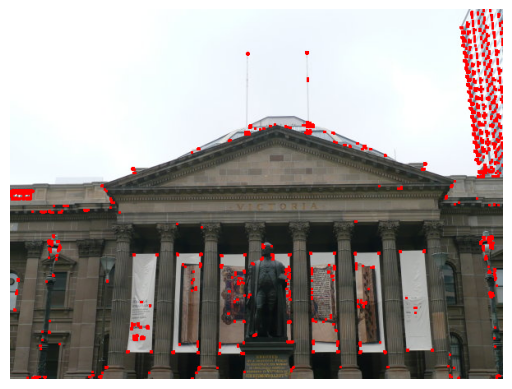

In [5]:
# Show you result here

def load_and_display_image(image_path):
    # Load image and detect corners
    img = cv2.imread(image_path)
    img_with_corners = detect_corner(img)

    # Display the image
    plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Apply on the specified image
image_path = '/content/train_images/Set1/1.jpg'
load_and_display_image(image_path)

#### Step 2: Adaptive Non-Maximal Suppression (or ANMS)

The objective of this step is to detect corners such that they are equally distributed across the image in order to avoid weird artifacts in warping.

In a real image, a corner is never perfectly sharp, each corner might get a lot of hits out of the **N**
 strong corners - we want to choose only the **$N_{best}$**
 best corners after ANMS. In essence, you will get a lot more corners than you should! ANMS will try to find corners which are true local maxima. The algorithm for implementing ANMS is given below.



In [6]:
### Adaptive Non-Maximal Suppression (or ANMS)
# Perform ANMS: Adaptive Non-Maximal Suppression
# Show ANMS output as an image
import numpy as np

def ANMS(cmap, num_best):
    """
    Perform Adaptive Non-Maximal Suppression.

    cmap: corner metric map, output from corner detection methods like Harris.
    num_best: number of best corners to keep.

    Returns:
    y_best, x_best : Y and X coordinates of best corners.
    """

    # Get the coordinates of all non-zero corners from cmap
    corners = np.argwhere(cmap > 0)
    num_corners = len(corners)

    # Store the smallest distance
    min_dist = np.full(num_corners, np.inf)
    for i in range(num_corners):
        y, x = corners[i]

        # Calculate sum of squared differences
        dists = np.sum((corners - np.array([y, x]))**2, axis=1)

        # For corners that have a stronger response
        stronger_corners = np.where(cmap[corners[:, 0], corners[:, 1]] > cmap[y, x])

        # Update the minimum distance if it's closer and stronger
        if len(stronger_corners[0]) > 0:
            min_dist[i] = np.min(dists[stronger_corners])

    # Sort the corners and get the num_best ones
    best_corners = np.argsort(min_dist)[-num_best:]
    return corners[best_corners][:, 0], corners[best_corners][:, 1]

# Source: https://cmsc426.github.io/pano/

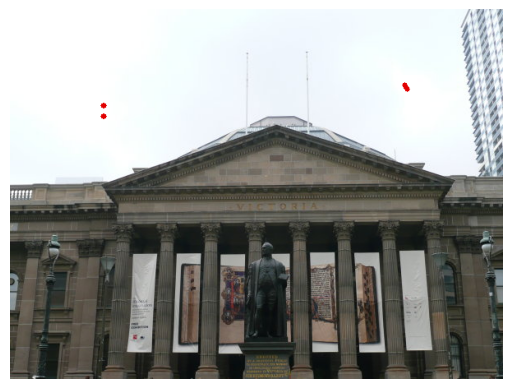

In [26]:
# Show you result here

import cv2
import matplotlib.pyplot as plt

def detect_corners_with_ANMS(img, num_best=100):
    # Use grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Harris corner detection to get the corner metric map
    # Use a threshold to identify strong corners
    cmap = cv2.cornerHarris(gray, 9, 5, 0.20)
    dst = cv2.dilate(cmap, None)
    cmap[dst < 0.01 * dst.max()] = 0

    # Apply ANMS using the given function
    y_best, x_best = ANMS(cmap, num_best)

    return list(zip(y_best, x_best))

def load_and_display_image_ANMS(img, num_best= 100, show=True):
    # Apply corner detection with ANMS
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Harris corner detection to get the corner metric map
    # Use a threshold to identify strong corners
    cmap = cv2.cornerHarris(gray, 9, 5, 0.20)
    dst = cv2.dilate(cmap, None)
    cmap[dst < 0.01 * dst.max()] = 0

    # Apply ANMS using the given function
    y_best, x_best = ANMS(cmap, num_best)

    # Draw circles to highlight the corners
    img_with_corners = img.copy()
    for y, x in zip(y_best, x_best):
        cv2.circle(img_with_corners, (x, y), 3, (0, 0, 225), -1)

    # Display the image with corners
    if show:
      plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

    return list(zip(y_best, x_best))

# Apply on the specified image
image_path = '/content/train_images/Set1/1.jpg'
curr_image = cv2.imread(image_path)
anms_best_corners = load_and_display_image_ANMS(curr_image, num_best = 150)

# Source: https://cmsc426.github.io/pano/

### 2. Feature Descriptors: [15pts]

In the previous step, you found the feature points (locations of the Nbest
 best corners after ANMS are called the feature point locations). You need to describe each feature point by a feature vector, this is like encoding the information at each feature point by a vector. One of the easiest feature descriptor is described next.

Take a patch of **size 40×40**
 centered **(this is very important**) around the keypoint/feature point. Now apply gaussian blur (feel free to play around with the parameters, for a start you can use OpenCV’s default parameters in **cv2.GaussianBlur** command. Now, sub-sample the blurred output (this reduces the dimension) to 8×8
. Then reshape to obtain a 64×1
 vector. Standardize the vector to have zero mean and variance of 1. Standardization is used to remove bias and to achieve some amount of illumination invariance.

In [8]:
import numpy as np
import cv2

def feature_descript(gray_img, corners):
    # Define the patch size and the resulting size after subsampling
    # Define the Gaussian blur kernel size
    patch_size = 40
    result_size = 8
    kernel_size = (3, 3)

    # Padding the image to handle edge keypoints
    padded_img = cv2.copyMakeBorder(gray_img, patch_size//2, patch_size//2, patch_size//2, patch_size//2, cv2.BORDER_REFLECT)
    corners = np.array(corners, dtype=int) + patch_size // 2
    patches = [padded_img[y-patch_size//2:y+patch_size//2, x-patch_size//2:x+patch_size//2] for y, x in corners]

    # Apply Gaussian blur to create the features
    descriptors = []
    for patch in patches:
        blurred_patch = cv2.GaussianBlur(patch, kernel_size, 0)
        sub_sampled_patch = blurred_patch[::patch_size//result_size, ::patch_size//result_size]

        # We want to turn the region into a feature vector
        feature_vector = sub_sampled_patch.reshape(64, 1)
        mean = np.mean(feature_vector)
        std = np.std(feature_vector)
        standardized_feature_vector = (feature_vector - mean) / std
        descriptors.append(standardized_feature_vector)

    return np.array(descriptors)

# Source: https://cmsc426.github.io/pano/

In [9]:
# Load a test image
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the features
features = feature_descript(gray, anms_best_corners)
features.shape

(150, 64, 1)

### 3. Feature Matching: [15pts]

In the previous step, you encoded each keypoint by **64×1**
 feature vector. Now, you want to match the feature points among the two images you want to stitch together. In computer vision terms, this step is called as finding feature correspondences between the 2 images. Pick a point in image 1, compute sum of square differences between all points in image 2. Take the ratio of best match (lowest distance) to the second best match (second lowest distance) and if this is below some ratio keep the matched pair or reject it. Repeat this for all points in image 1. You will be left with only the confident feature correspondences and these points will be used to estimate the transformation between the 2 images, also called as Homography. Use the function **cv2.drawMatches** to visualize feature correspondences. Below is an image showing matched features.



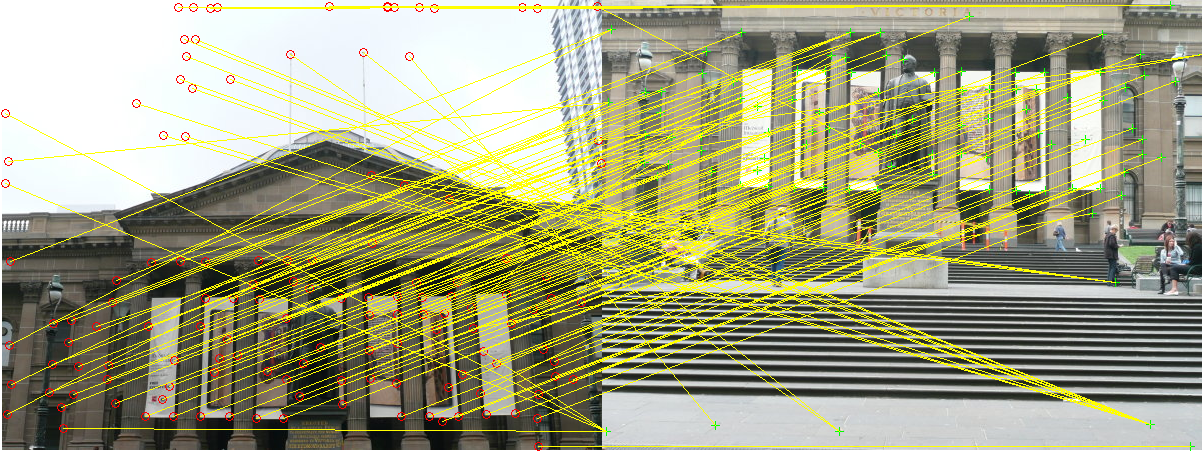

In [10]:
### Feature matching
def feature_match(img1, img2, corner1, corner2):

  # For every corner in image1, match it with a corner in image2
  matches = []
  threshold = 0.4
  for c1_index, c1 in enumerate(corner1):

    # Calculate the difference to every corner in image2
    squared_differences = []
    for c2_index, c2 in enumerate(corner2):
      if c1_index == c2_index:
        continue

      sum_of_squared_differences = sum((c1 - c2)**2)[0]
      squared_differences.append(sum_of_squared_differences)

    # The best match is the one with the smallest error and satisfies the threshold
    sorted_differences = np.argsort(squared_differences)
    best_diff_index = sorted_differences[0]
    second_best_diff_index = sorted_differences[1]
    ratio = squared_differences[best_diff_index]/squared_differences[second_best_diff_index]
    if ratio < threshold:
      matches.append([c1_index, best_diff_index])

  return matches

# Source: https://cmsc426.github.io/pano/

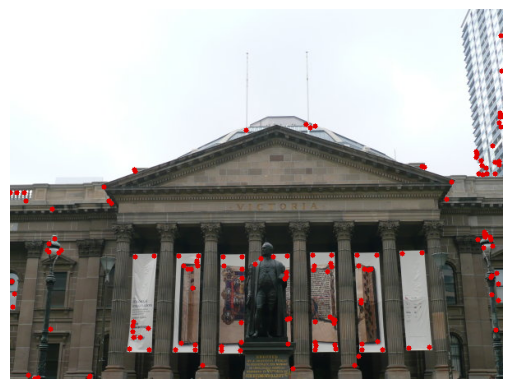

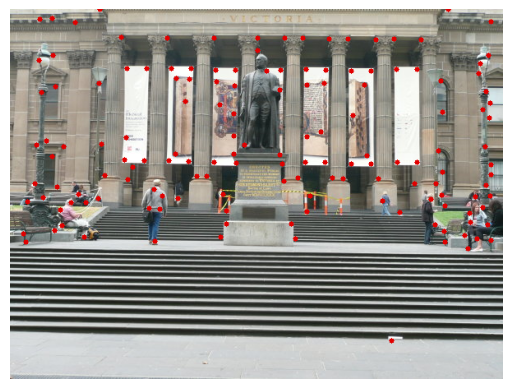

In [11]:
# Load in two samples images
image_path_1 = '/content/train_images/Set1/1.jpg'
image_path_2 = '/content/train_images/Set1/2.jpg'
img1 = cv2.imread(image_path_1)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(image_path_2)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Find the corners in the images
anms_best_corners1 = load_and_display_image_ANMS(img1, num_best = 150)
anms_best_corners2 = load_and_display_image_ANMS(img2, num_best = 150)

# Find the features in the images
features1 = feature_descript(gray1, anms_best_corners1)
features2 = feature_descript(gray2, anms_best_corners2)

In [12]:
# Match the features in the two images
matches = feature_match(img1, img2, features1, features2)

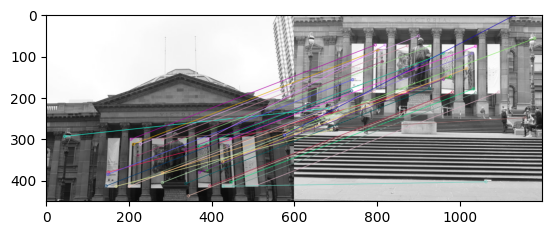

In [13]:
# Use OpenCV to visualize the matched features in the two images
final_kp1, final_kp2 = [], []
for i in range(len(anms_best_corners1)):
  (x, y) = anms_best_corners1[i]
  (x, y) = float(y), float(x)
  keypoint = cv2.KeyPoint(x, y, 0)
  final_kp1.append(keypoint)
  (x, y) = anms_best_corners2[i]
  (x, y) = float(y), float(x)
  keypoint = cv2.KeyPoint(x, y, 0)
  final_kp2.append(keypoint)

dmatch_list = []
for match_ in matches:
    query_idx, train_idx = match_
    distance = 0
    dmatch = cv2.DMatch(_queryIdx=query_idx, _trainIdx=train_idx, _distance=distance)
    dmatch_list.append(dmatch)

img3 = cv2.drawMatches(gray1, final_kp1, gray2, final_kp2, dmatch_list, None, flags=2)
plt.imshow(img3)

# Source: https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html

### 4. RANSAC for outlier rejection and to estimate Robust Homography: [20pts]


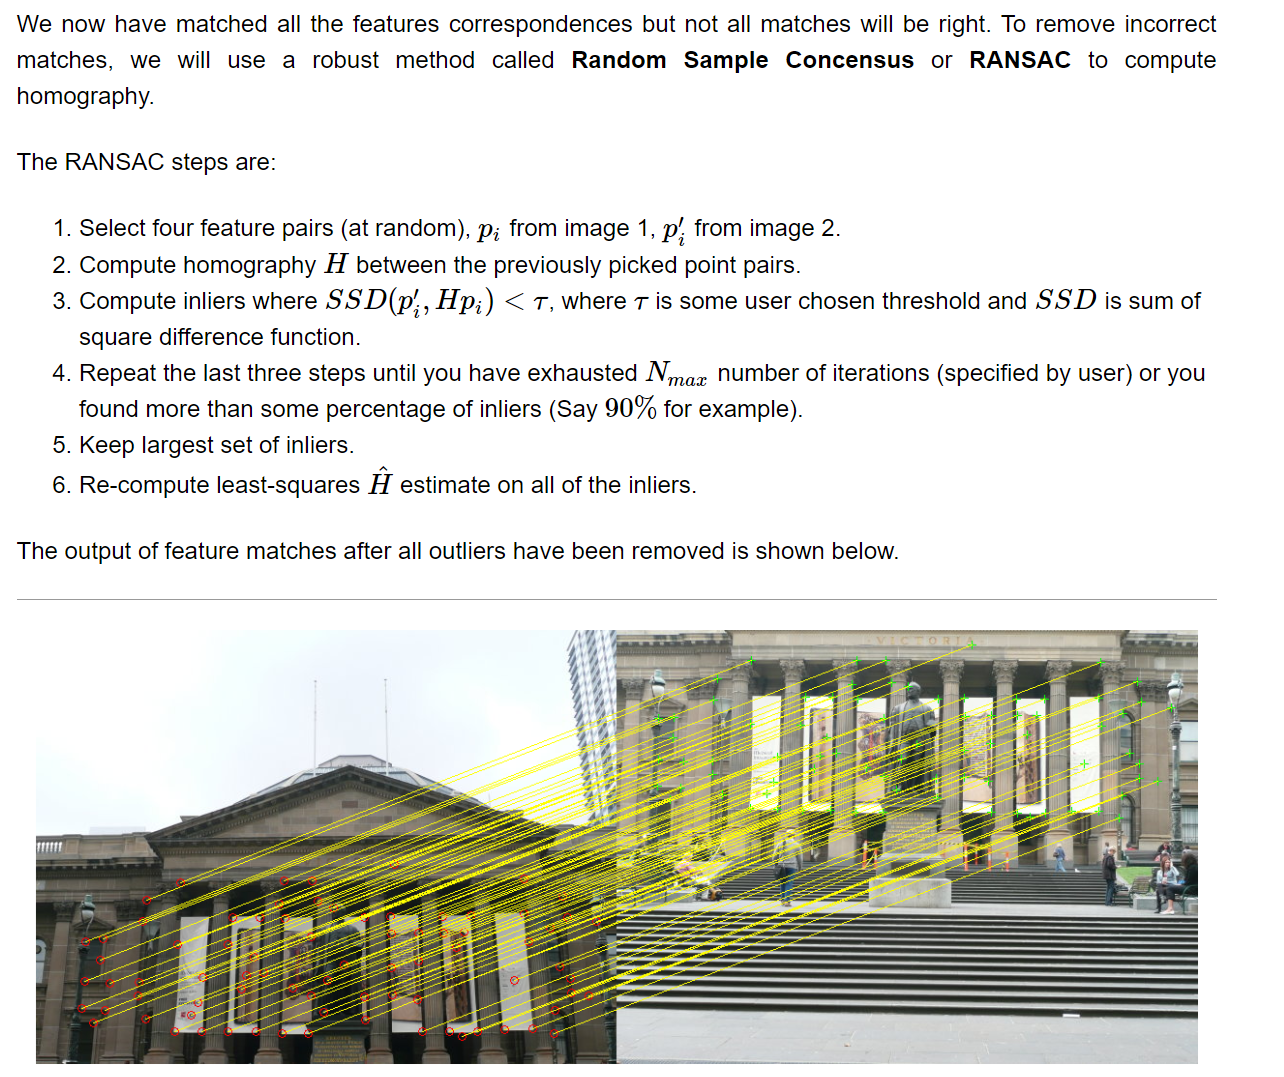

In [14]:
from numpy.random.mtrand import noncentral_f

# Given 4 points from both images, compute the homography
def computeHomography(image1points, image2points):
  try:
    # Initialize A, which represents the points in the first image
    image1_xs = image1points[:, 0]
    image1_ys = image1points[:, 1]
    M = np.array([
        [image1_xs[0], image1_xs[1], image1_xs[2]],
        [image1_ys[0], image1_ys[1], image1_ys[2]],
        [1, 1, 1]
    ])
    x = np.array([
        [image1_xs[3]],
        [image1_ys[3]],
        [1]
    ])
    scaling = np.matmul(np.linalg.inv(M),x)
    A = M*scaling.T

    # Initialize B, which represents the points in the second image
    image2_xs = image2points[:, 0]
    image2_ys = image2points[:, 1]
    M = np.array([
        [image2_xs[0], image2_xs[1], image2_xs[2]],
        [image2_ys[0], image2_ys[1], image2_ys[2]],
        [1, 1, 1]
    ])
    x = np.array([
        [image2_xs[3]],
        [image2_ys[3]],
        [1]
    ])
    scaling = np.matmul(np.linalg.inv(M),x)
    B = M*scaling.T

    # We will compute the homography by multiplying B with the inverse of A
    H = np.matmul(B, np.linalg.inv(A))
    return H

  except:
    return None

In [15]:
# Calculate Homography from a set of source and destination points
def computeHomographyNPoints(src_pts, dest_pts):
  # Create a Matrix A to house the N points
  num_pts = len(src_pts)
  A = np.zeros((2 * num_pts, 9))
  for i in range(num_pts):
      x_src, y_src = src_pts[i]
      x_dest, y_dest = dest_pts[i]
      A[2*i] = [-x_src, -y_src, -1, 0, 0, 0, x_src*x_dest, y_src*x_dest, x_dest]
      A[2*i+1] = [0, 0, 0, -x_src, -y_src, -1, x_src*y_dest, y_src*y_dest, y_dest]

  # Use Singular Value Decomposition to get the least squares solution
  # The homography is the last column of V
  _, _, VT = np.linalg.svd(A)
  h = VT[-1, :].reshape(3, 3)

  return h

In [16]:
import random

# Ransac to filter out the wrong matchings and return homography
def RANSAC(match_kp1, match_kp2, N, threshold):

  largest_set_of_inliers = []
  if len(match_kp1) < 4:
      return [], None, None

  # Run RANSAC N times
  for iter in range(N):
    current_inliers = []

    # Select 4 random points to create a homography
    indices = np.array(random.sample(range(len(match_kp1)), 4))
    H = computeHomography(match_kp1[indices], match_kp2[indices])

    if H is None:
      continue

    # Apply the computed hompgraphy with on the pairs
    for i in range(len(match_kp2)):
      # Use the computed homography
      p0 = match_kp1[i]
      homographied_p0 = np.concatenate([p0, [1]])
      homographied_p0_reshaped = homographied_p0.reshape((3, 1))
      est_p1 = np.matmul(H, homographied_p0_reshaped)
      est_p1 = est_p1.flatten()[:2]
      actual_p1 = match_kp2[i]

      # Compute the sum of squared distances
      SSD = sum((est_p1 - actual_p1)**2)

      # If the error is lower than the threshold, add it as an inlier
      if SSD < threshold:
        current_inliers.append((i, i))

    # Save the largest set of inliers
    if len(current_inliers) > len(largest_set_of_inliers):
      largest_set_of_inliers = current_inliers

  # Represent the largest set of inliers with two arrays
  source_points, dest_points = [], []
  for inlier in largest_set_of_inliers:
    (x1, y1) = match_kp1[inlier[0]]
    source_points.append([y1, x1])
    (x2, y2) = match_kp2[inlier[0]]
    dest_points.append([y2, x2])
  source_points = np.array(source_points, dtype = np.float32)
  dest_points = np.array(dest_points, dtype = np.float32)

  if len(source_points) < 4 or len(dest_points)<4:
    return [], None, None

  # Let's compute the homography of these inliers
  finalHomography = computeHomographyNPoints(source_points, dest_points)
  t = [0,0]
  return largest_set_of_inliers, finalHomography, t

# Source: https://cmsc426.github.io/pano/

In [17]:
# Show you result here

# Use RANSAC to filter out some matched pairs of corners
corners1, corners2 = [], []
for match_ in matches:
  (x, y) = match_
  corners1.append(anms_best_corners1[x])
  corners2.append(anms_best_corners2[y])
corners1 = np.array(corners1)
corners2 = np.array(corners2)

good_pairs, finalHomography, t = RANSAC(corners1, corners2, N = 1000, threshold = 1000)

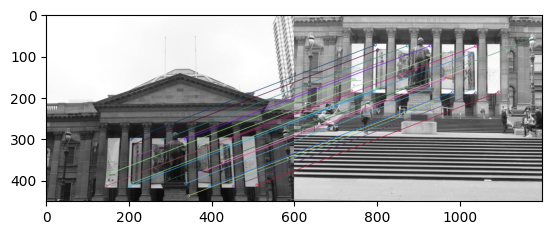

In [18]:
# To validate our RANSAC filtering, let's plot the matching features
final_kp1, final_kp2 = [], []
for i in range(len(corners1)):
  (x, y) = corners1[i]
  (x, y) = float(y), float(x)
  keypoint = cv2.KeyPoint(x, y, 0)
  final_kp1.append(keypoint)
  (x, y) = corners2[i]
  (x, y) = float(y), float(x)
  keypoint = cv2.KeyPoint(x, y, 0)
  final_kp2.append(keypoint)

dmatch_list = []
for match_ in good_pairs:
    query_idx, train_idx = match_
    distance = 0  # You can specify the distance if available
    dmatch = cv2.DMatch(_queryIdx=query_idx, _trainIdx=train_idx, _distance=distance)
    dmatch_list.append(dmatch)

# Use OpenCV to plot the filtered matches corners
img3 = cv2.drawMatches(gray1, final_kp1, gray2, final_kp2, dmatch_list, None, flags=2)
plt.imshow(img3)

# Source: https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html

### 5. Image Warping (and Blending): [25pts]

Panorama can be produced by overlaying the pairwise aligned images to create the final output image. The output panorama stitched from two images shown in the figure below.

When blending these images, there are inconsistency between pixels from different input images due to different exposure/white balance settings or photometric distortions or vignetting. This can be resolved by [Poisson blending](http://www.irisa.fr/vista/Papers/2003_siggraph_perez.pdf). You can use third party code only for the seamless panorama stitching.

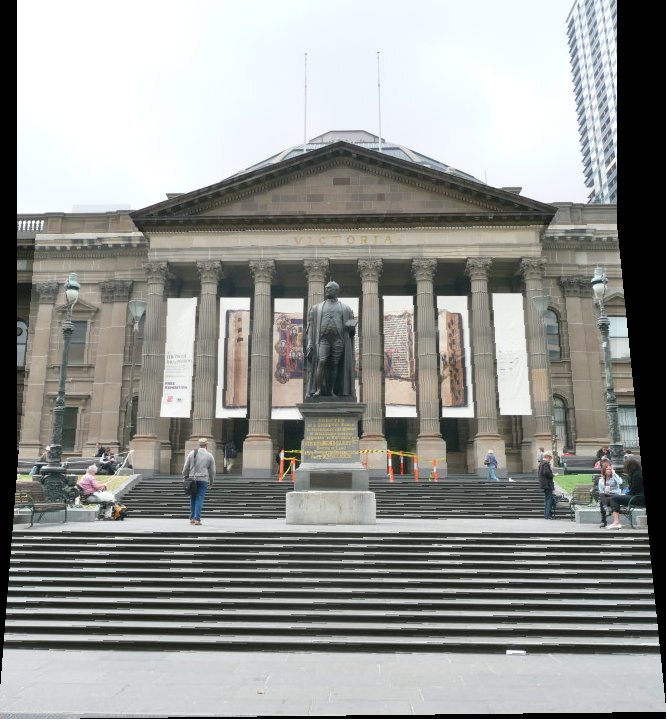

In [19]:
# Image Blending Source:
# https://stackoverflow.com/questions/64659657/fast-and-robust-image-stitching-algorithm-for-many-images-in-python

def warpRect(rect, H):
    x, y, w, h = rect
    corners = np.array([[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]], dtype=np.float32)
    corners = np.array([corners])

    # Warp the corners of the rectangle using the homography matrix
    warped_corners = cv2.perspectiveTransform(corners, H)

    # Find the minimum and maximum coordinates of the warped corners
    minx, miny = np.min(warped_corners[:, :, 0]), np.min(warped_corners[:, :, 1])
    maxx, maxy = np.max(warped_corners[:, :, 0]), np.max(warped_corners[:, :, 1])

    xo = int(np.floor(minx))
    yo = int(np.floor(miny))
    wo = int(np.ceil(maxx - minx))
    ho = int(np.ceil(maxy - miny))
    outrect = (xo, yo, wo, ho)

    return outrect


def coverH(rect, H):
    # obtain bounding box of the result
    x, y, _, _ = warpRect(rect, H)
    # shift amount to the first quadrant
    xpos = int(-x if x < 0 else 0)
    ypos = int(-y if y < 0 else 0)
    # correct the homography matrix so that no point is thrown out
    T = np.array([[1, 0, xpos], [0, 1, ypos], [0, 0, 1]])
    H_corr = T.dot(H)
    return (H_corr, (xpos, ypos))

# pad image to cover ROI, return the shift amount of origin
def addBorder(img, rect):
    x, y, w, h = rect
    tl = (x, y)
    br = (x + w, y + h)
    top = int(-tl[1] if tl[1] < 0 else 0)
    bottom = int(br[1] - img.shape[0] if br[1] > img.shape[0] else 0)
    left = int(-tl[0] if tl[0] < 0 else 0)
    right = int(br[0] - img.shape[1] if br[0] > img.shape[1] else 0)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    orig = (left, top)
    return img, orig

def size2rect(size):
    return (0, 0, size[1], size[0])

def warpImage(img, H):
    # tweak the homography matrix to move the result to the first quadrant
    H_cover, pos = coverH(size2rect(img.shape), H)
    # find the bounding box of the output
    x, y, w, h = warpRect(size2rect(img.shape), H_cover)
    width, height = x + w, y + h
    # warp the image using the corrected homography matrix
    warped = cv2.warpPerspective(img, H_cover, (width, height))
    # make the external boundary solid black, useful for masking
    warped = np.ascontiguousarray(warped, dtype=np.uint8)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    _, bw = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # https://stackoverflow.com/a/55806272/12447766
    major = cv2.__version__.split('.')[0]
    if major == '3':
        _, cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    else:
        cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    warped = cv2.drawContours(warped, cnts, 0, [0, 0, 0], lineType=cv2.LINE_4)
    return (warped, pos)

def mean_blend(img1, img2):
    assert(img1.shape == img2.shape)
    locs1 = np.where(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) != 0)
    blended1 = np.copy(img2)
    blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
    locs2 = np.where(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) != 0)
    blended2 = np.copy(img1)
    blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
    blended = cv2.addWeighted(blended1, 0.5, blended2, 0.5, 0)
    return blended

def warpPano(prevPano, img, H, orig):
    # correct homography matrix
    T = np.array([[1, 0, -orig[0]], [0, 1, -orig[1]], [0, 0, 1]])
    H_corr = H.dot(T)
    # warp the image and obtain shift amount of origin
    result, pos = warpImage(prevPano, H_corr)
    xpos, ypos = pos
    # zero pad the result
    rect = (xpos, ypos, img.shape[1], img.shape[0])
    result, _ = addBorder(result, rect)
    # mean value blending
    idx = np.s_[ypos : ypos + img.shape[0], xpos : xpos + img.shape[1]]
    result[idx] = mean_blend(result[idx], img)
    # crop extra paddings
    x, y, w, h = cv2.boundingRect(cv2.cvtColor(result, cv2.COLOR_RGB2GRAY))
    result = result[y : y + h, x : x + w]
    # return the resulting image with shift amount
    return (result, (xpos - x, ypos - y))

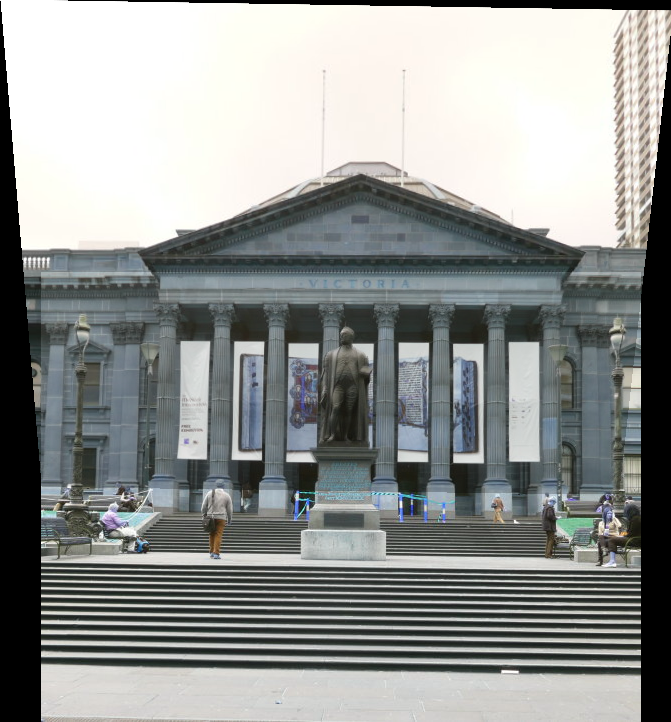

In [20]:
# Let's blend two images
src_image = mpimg.imread('/content/train_images/Set1/1.jpg')
dst_image = mpimg.imread('/content/train_images/Set1/2.jpg')

# Remember that we computed the homography for these two images earlier
homography_matrix = finalHomography

# Let's blend two images together with the calculated homography
# Use the third party code to blend
img, _ = warpPano(src_image, dst_image, homography_matrix, (0, 0))
cv2_imshow(img)

### 6. Putting Everything Together (Stitching more than 2 images)

In [21]:
import os

# Take in a list of images and stitch them together!
def pano_imgs(img_list):

  # Use the first image as a base image
  prev_image = img_list[0]

  for i in range(1, len(img_list)):
    curr_image = img_list[i]

    # Get the grayscale images of both
    gray1 = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

    # Find the corners and features
    anms_best_corners1 = detect_corners_with_ANMS(prev_image, num_best = 200)
    anms_best_corners2 = detect_corners_with_ANMS(curr_image, num_best = 200)
    features1 = feature_descript(gray1, anms_best_corners1)
    features2 = feature_descript(gray2, anms_best_corners2)

    # Match the features of the two images
    matches = feature_match(prev_image, curr_image, features1, features2)
    corners1, corners2 = [], []
    for match_ in matches:
      (x, y) = match_
      corners1.append(anms_best_corners1[x])
      corners2.append(anms_best_corners2[y])
    corners1 = np.array(corners1)
    corners2 = np.array(corners2)

    # After using RANSAC to filter out matched corners, compute the homography
    good_pairs, finalHomography, t = RANSAC(corners1, corners2, N = 100, threshold = 1000)
    if t is None or t[0] is None:
      continue
    if finalHomography is None:
      continue

    # Apply the homography to blend the images
    homography_matrix = finalHomography
    prev_image, _ = warpPano(prev_image, img_list[i], homography_matrix, (0, 0))

  return prev_image

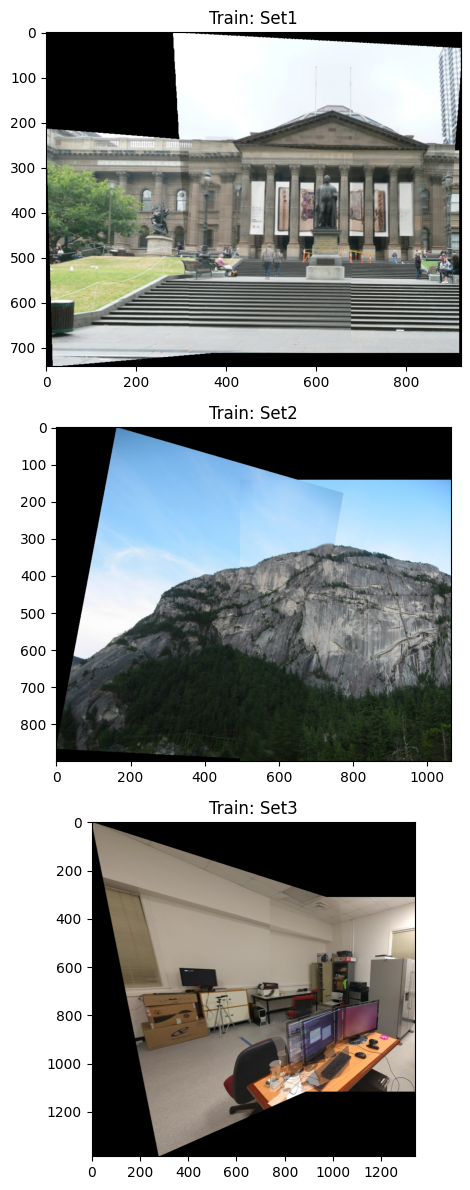

In [24]:
# Show you result here
output = []

train_dir = "/content/train_images"
trainings = ["Set1", "Set2", "Set3"]

for training in trainings:
  # Add all of the images in a scene to an array
  imgs = []
  curr_train_dir = os.path.join(train_dir, training)
  for filename in os.listdir(curr_train_dir):
      if filename[-4:] == ".jpg":
        imgs.append(cv2.imread(os.path.join(curr_train_dir, filename)))
  # Create the pano image using the list of images
  output.append((training, pano_imgs(imgs)))

# Display the blended images
fig, axes = plt.subplots(3, 1, figsize=(36, 12))
for i, ax in enumerate(axes.ravel()):
  if i < len(output):
    name, blended_img = output[i]
    ax.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))
    ax.set_title(
        f"Train: {name}"
    )

plt.tight_layout()
plt.show()

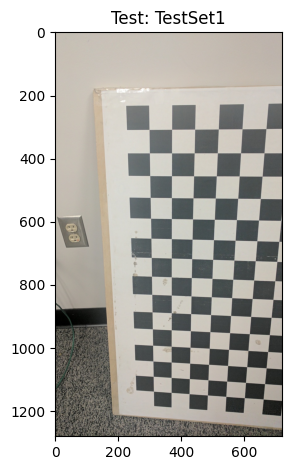

In [31]:
# Test Images
output = []
test_dir = "/content/test_images"
tests = ["TestSet1"]


for test in tests:
  # Add all of the images in a scene to an array
  imgs = []
  curr_test_dir = os.path.join(test_dir, test)
  for filename in os.listdir(curr_test_dir):
      if filename[-4:] == ".jpg":
        imgs.append(cv2.imread(os.path.join(curr_test_dir, filename)))
  # Create the pano image using the list of images
  output.append((test, pano_imgs(imgs)))

# Display the blended images
name, blended_img = output[0]
plt.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))
plt.title(
    f"Test: {name}"
)

plt.tight_layout()
plt.show()

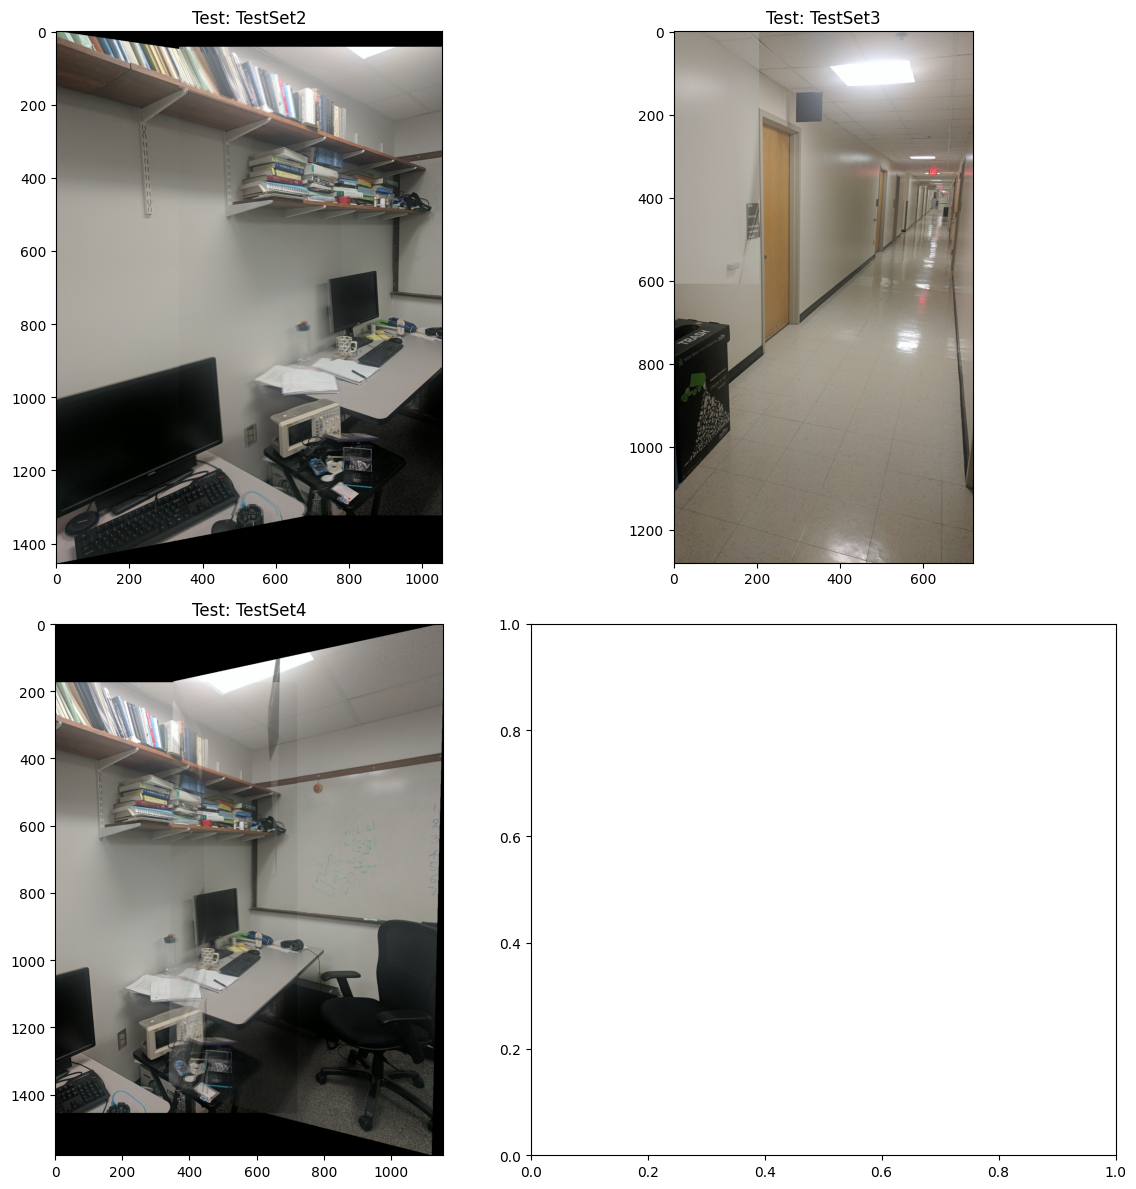

In [23]:
# Test Images
output = []
test_dir = "/content/test_images"
tests = ["TestSet2","TestSet3", "TestSet4"]


for test in tests:
  # Add all of the images in a scene to an array
  imgs = []
  curr_test_dir = os.path.join(test_dir, test)
  for filename in os.listdir(curr_test_dir):
      if filename[-4:] == ".jpg":
        imgs.append(cv2.imread(os.path.join(curr_test_dir, filename)))
  # Create the pano image using the list of images
  output.append((test, pano_imgs(imgs)))

# Display the blended images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, ax in enumerate(axes.ravel()):
  if i < len(output):
    name, blended_img = output[i]
    ax.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))
    ax.set_title(
        f"Test: {name}"
    )

plt.tight_layout()
plt.show()

## Report
You will be graded primarily based on your report.
A demonstration of understanding of the concepts involved in the project are required show the output produced by your code.

Include visualizations of the output of each stage in your pipeline (as shown in the system diagram on page 2), and a description of what you did for each step. Assume that we’re familiar with the project, so you don’t need to spend time repeating what’s already in the course notes. Instead, focus on any interesting problems you encountered and/or solutions you implemented.

Be sure to include the output panoramas for **all five image sets (from the training and test sets)**. Because you have limited time in which to access the “test set” images, we won’t expect in-depth analysis of your results for them.

As usual, your report must be full English sentences, **not** commented code. There is a word limit of 1500 words and no minimum length requirement.

TEST SET available **TBD on Piazza**

## Part 1 - Detect Corners and Adaptive Non-Maximal Suppression (or ANMS) 

The first step in blending images is to detect the corners within them. In our implementation, we used the cornerHarris function from OpenCV. This corner detection algorithm identifies areas where both horizontal and vertical derivatives are high. Once we've found the corners, our goal is to keep only the "best" and "strong" ones. Often, there are multiple points corresponding to the same corner in an image. Thus, we aim to retain only the strongest representation of that corner. These identified points can be considered as key points in the image. Through trial and error, we set parameters that were strict in detecting corners, enabling us to reduce duplicates effectively.

We chose points that represented local maxima - i.e. those that were the strongest in their region. Again, thresholding was used here so a suitable threshold had to be reached to identify both good corners and well spaced out corners.

## Part 2 - Feature Descriptor

Now that we have a list of unique key points in the image, we want a way to represent them in such a way that features can be compared with each other. The method we used was to take a gaussian blur of the region surrounding each corner to reduce the region to a 8 row by 8 column matrix. Then, we reshaped the matrix to become a 64 row vector. We did this process for each corner. We tried different kernel sizes and parameters to the gaussian blur function. In the end, spacing out the corners proved to yield more useful feature descriptors, since there was less overlap in the context windows and thus more unique and better matching feature descriptors.

## Part 3 - Feature Matching

Assuming that we have the features of two images, we can match corresponding features. This was done by comparing each feature in the first image to every other feature in the second image by using the sum of squared differences across corresponding elements of the vectors. If the ratio between the smallest and second smallest sum of squared differences was less than a threshold, then we found a match between feature vectors in the two images. The additional step of checking the ratio was used to ensure that candidates are close to one another. 

## Part 4 - RANSAC to estimate Robust Homography

Although we have found matchings between feature vectors, we only want to keep strong matchings. Furthermore, we want to compute a homography between two images to blend the images in the next step. In each iteration of the RANSAC algorithm, we choose 4 random pairs of features to create an estimated homography. We then use this estimated homography to predict the location of points from the first image to its corresponding point in the second image. If the sum of squared differences is lower than a threshold, we define this as an inlier. At each step, we will keep track of the number of inliers each estimated homography produced. After N iterations, we want to compute the homography of the estimated homography that computed the most inliers. Furthermore, we also want to save the set of the largest set of feature pair inliers.

## Part 5 - Blending Images

With a homography calculated, we found code online that can blend two images given a homography. We have included a link to the source in our code. In order to blend a list of images, we first blended the first two images together, and blended the rest of the images one-by-one. In other words, we continuously blended more images until every image has been added to the panorama.

## Failures:

Our program seems to be having trouble when blending more than 3 images. We played around with parameters for the gaussian blur, feature matching, corner detection, and number of corners to keep. We found that allowing more corners to be detected increased the time to blend the images significantly. We found a balance between time and accuracy.  

# Allowed Functions

For cv2 advanced functions, only these are allowed:
1. For feature detection: **cv2.cornerHarris**, **cv2.cornerHarris**
2. For drawing matches: **cv2.drawMatches**
3. For estimate homograhy and warping: **cv2.getPerspectiveTransform**, **cv2.warpPerspective**

# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj2.pdf**. For example, xyz123_proj2.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.